In [1]:
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from cv2 import imread
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from pylab import imshow, show
import timeit


import keras
from keras.layers import Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import ResNet50, VGG19

import warnings
warnings.filterwarnings("ignore")

In [2]:
start = timeit.default_timer()
path = "../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset"

image_generator = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=2, 
    vertical_flip=2, 
    validation_split=0.2)   

training_set = image_generator.flow_from_directory(batch_size=16,
                                                 directory=path,
                                                 shuffle=True,
                                                 target_size=(224,224), 
                                                 subset="training",
                                                 color_mode='rgb',
                                                 class_mode='binary')

testing_set = image_generator.flow_from_directory(batch_size=16,
                                                 directory=path,
                                                 shuffle=True,
                                                 target_size=(224,224), 
                                                 subset="validation",
                                                 color_mode='rgb',
                                                 class_mode='binary')

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


<h4>Tumour MRI Image</h4>

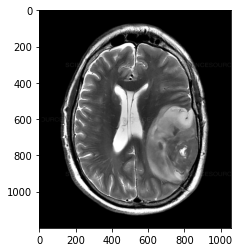

In [3]:
yes_path = path+"/yes/"+os.listdir(path+"/yes/")[4]
tumour = imread(yes_path)
plt.imshow(tumour)

<h4>Normal MRI Image</h4>

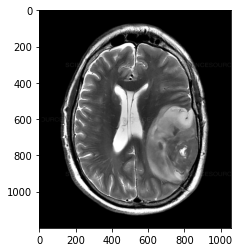

In [4]:
no_path = path+"/no/"+os.listdir(path+"/no/")[4]
tumour = imread(yes_path)
plt.imshow(tumour)

In [5]:
testing_set.class_indices

{'no': 0, 'yes': 1}

<h3>VGG 19</h3>

In [6]:
model = VGG19(
      input_shape = (224,224,3),
      include_top = False,
      weights = 'imagenet'
    )


80150528/80134624 [==============================] - 0s 0us/step


In [7]:
for layers in model.layers:
    layers.trainable = False

In [8]:
x = Flatten()(model.output)
x = Dropout(0.4)(x)
x = Dense(1, activation = "sigmoid")(x)

model = keras.Model(model.input, x)
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = "accuracy")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
hist = model.fit_generator(training_set,validation_data = testing_set, epochs = 60)

Epoch 1/60
13/13 [==============================] - 12s 304ms/step - loss: 0.7057 - accuracy: 0.6453 - val_loss: 0.4949 - val_accuracy: 0.8000
Epoch 2/60
13/13 [==============================] - 1s 100ms/step - loss: 0.4849 - accuracy: 0.7980 - val_loss: 0.4808 - val_accuracy: 0.7200
Epoch 3/60
13/13 [==============================] - 1s 100ms/step - loss: 0.4093 - accuracy: 0.8177 - val_loss: 0.4153 - val_accuracy: 0.8000
Epoch 4/60
13/13 [==============================] - 1s 103ms/step - loss: 0.3470 - accuracy: 0.8522 - val_loss: 0.3730 - val_accuracy: 0.7800
Epoch 5/60
13/13 [==============================] - 1s 100ms/step - loss: 0.2996 - accuracy: 0.8818 - val_loss: 0.3567 - val_accuracy: 0.8000
Epoch 6/60
13/13 [==============================] - 1s 109ms/step - loss: 0.3430 - accuracy: 0.8424 - val_loss: 0.3534 - val_accuracy: 0.8000
Epoch 7/60
13/13 [==============================] - 1s 98ms/step - loss: 0.2885 - accuracy: 0.8966 - val_loss: 0.3541 - val_accuracy: 0.8200
Epoch 

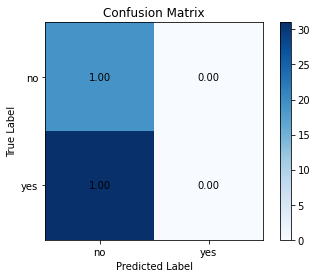

True Positives (TP): 0
True Negatives (TN): 19
False Positives (FP): 0
False Negatives (FN): 31
Accuracy: 0.38
Precision: nan
Recall (Sensitivity): 0.0
Specificity: 1.0
F1 Score: nan


In [10]:
# Step 2: Predict labels for the test set
y_true = testing_set.classes
y_pred = model.predict(testing_set).argmax(axis=-1)

# Step 3: Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Plot the confusion matrix as a heatmap
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     # Display the values in the heatmap
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, "{:.2f}".format(cm_normalized[i, j]),
                     ha='center', va='center')

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Get the class labels from the data generator
class_labels = list(testing_set.class_indices.keys())

# Plot the confusion matrix
plot_confusion_matrix(cm, classes=class_labels)

# Extracting True Positives (TP)
tp = cm[1, 1]

# Extracting True Negatives (TN)
tn = cm[0, 0]

# Extracting False Positives (FP)
fp = cm[0, 1]

# Extracting False Negatives (FN)
fn = cm[1, 0]
# Calculate Accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Calculate Precision
precision = tp / (tp + fp)

# Calculate Recall (Sensitivity)
recall = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

# Calculate F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

print("True Positives (TP):", tp)
print("True Negatives (TN):", tn)
print("False Positives (FP):", fp)
print("False Negatives (FN):", fn)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("Specificity:", specificity)
print("F1 Score:", f1_score)

In [11]:
hist = hist.history

Text(0, 0.5, 'accuracy')

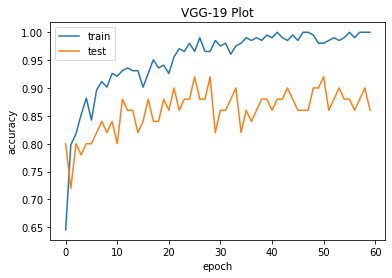

In [12]:
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("VGG-19 Plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")

Text(0, 0.5, 'loss')

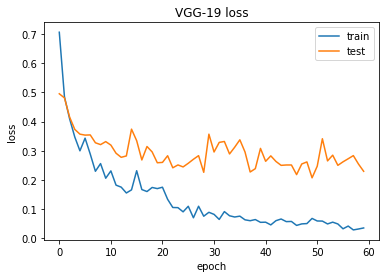

In [13]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("VGG-19 loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")

In [14]:
# Access the training and validation accuracy values
train_accuracy = hist["accuracy"]
val_accuracy = hist["val_accuracy"]

# Get the overall accuracy (final accuracy after training)
overall_train_accuracy = train_accuracy[-1]
overall_val_accuracy = val_accuracy[-1]

# Print the overall accuracy
print(f"Overall Training Accuracy: {overall_train_accuracy:.4f}")
print(f"Overall Validation Accuracy: {overall_val_accuracy:.4f}")

evaluation_result = model.evaluate(testing_set)

# Extract the accuracy from the evaluation result
overall_accuracy = evaluation_result[1]

# Print the overall accuracy
print(f"Overall Model Accuracy: {overall_accuracy:.4f}")

Overall Training Accuracy: 1.0000
Overall Validation Accuracy: 0.8600
4/4 [==============================] - 0s 50ms/step - loss: 0.2447 - accuracy: 0.8800
Overall Model Accuracy: 0.8800


We can notice that the accuracy is increasing as the number of epochs is increasing and loss is decreasing as the epochs is increasing

<h3>ResNet 50</h3>

In [15]:
model = ResNet50(
      input_shape = (224,224,3),
      include_top = False,
      weights = 'imagenet'
    )


94781440/94765736 [==============================] - 1s 0us/step


In [16]:
for layers in model.layers:
    layers.trainable = False

In [17]:
x = Flatten()(model.output)
x = Dropout(0.4)(x)
x = Dense(1, activation = "sigmoid")(x)

model = keras.Model(model.input, x)
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = "accuracy")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [18]:
hist = model.fit_generator(training_set,validation_data = testing_set, epochs = 60)

Epoch 1/60
13/13 [==============================] - 5s 193ms/step - loss: 2.6098 - accuracy: 0.5025 - val_loss: 2.1171 - val_accuracy: 0.6200
Epoch 2/60
13/13 [==============================] - 1s 97ms/step - loss: 1.2768 - accuracy: 0.6256 - val_loss: 1.0040 - val_accuracy: 0.6400
Epoch 3/60
13/13 [==============================] - 1s 95ms/step - loss: 0.9078 - accuracy: 0.6897 - val_loss: 1.1158 - val_accuracy: 0.7000
Epoch 4/60
13/13 [==============================] - 1s 96ms/step - loss: 0.7138 - accuracy: 0.7586 - val_loss: 1.0203 - val_accuracy: 0.6200
Epoch 5/60
13/13 [==============================] - 1s 106ms/step - loss: 0.5824 - accuracy: 0.8079 - val_loss: 0.9433 - val_accuracy: 0.7000
Epoch 6/60
13/13 [==============================] - 1s 95ms/step - loss: 0.5581 - accuracy: 0.7586 - val_loss: 0.7344 - val_accuracy: 0.7400
Epoch 7/60
13/13 [==============================] - 1s 98ms/step - loss: 0.6478 - accuracy: 0.7488 - val_loss: 0.6458 - val_accuracy: 0.7400
Epoch 8/60


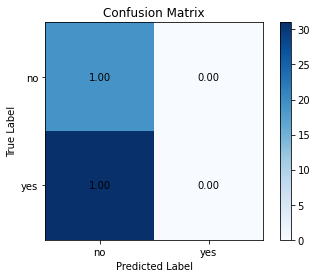

True Positives (TP): 0
True Negatives (TN): 19
False Positives (FP): 0
False Negatives (FN): 31
Accuracy: 0.38
Precision: nan
Recall (Sensitivity): 0.0
Specificity: 1.0
F1 Score: nan


In [19]:
# Step 2: Predict labels for the test set
y_true = testing_set.classes
y_pred = model.predict(testing_set).argmax(axis=-1)

# Step 3: Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Plot the confusion matrix as a heatmap
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     # Display the values in the heatmap
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, "{:.2f}".format(cm_normalized[i, j]),
                     ha='center', va='center')

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Get the class labels from the data generator
class_labels = list(testing_set.class_indices.keys())

# Plot the confusion matrix
plot_confusion_matrix(cm, classes=class_labels)

# Extracting True Positives (TP)
tp = cm[1, 1]

# Extracting True Negatives (TN)
tn = cm[0, 0]

# Extracting False Positives (FP)
fp = cm[0, 1]

# Extracting False Negatives (FN)
fn = cm[1, 0]
# Calculate Accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Calculate Precision
precision = tp / (tp + fp)

# Calculate Recall (Sensitivity)
recall = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

# Calculate F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

print("True Positives (TP):", tp)
print("True Negatives (TN):", tn)
print("False Positives (FP):", fp)
print("False Negatives (FN):", fn)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("Specificity:", specificity)
print("F1 Score:", f1_score)

In [20]:
hist = hist.history

Text(0, 0.5, 'accuracy')

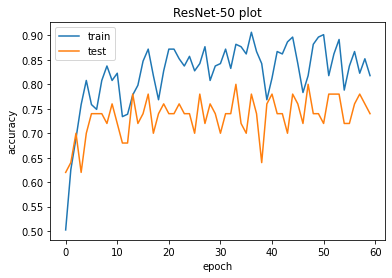

In [21]:
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("ResNet-50 plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")

Text(0, 0.5, 'loss')

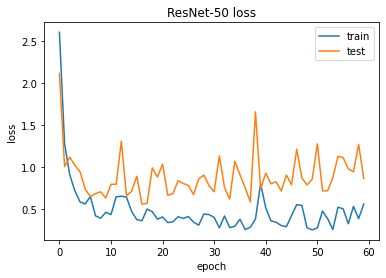

In [22]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("ResNet-50 loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")

In [23]:
# Access the training and validation accuracy values
train_accuracy = hist["accuracy"]
val_accuracy = hist["val_accuracy"]

# Get the overall accuracy (final accuracy after training)
overall_train_accuracy = train_accuracy[-1]
overall_val_accuracy = val_accuracy[-1]

# Print the overall accuracy
print(f"Overall Training Accuracy: {overall_train_accuracy:.4f}")
print(f"Overall Validation Accuracy: {overall_val_accuracy:.4f}")
evaluation_result = model.evaluate(testing_set)

# Extract the accuracy from the evaluation result
overall_accuracy = evaluation_result[1]

# Print the overall accuracy
print(f"Overall Model Accuracy: {overall_accuracy:.4f}")


Overall Training Accuracy: 0.8177
Overall Validation Accuracy: 0.7400
4/4 [==============================] - 0s 53ms/step - loss: 0.9558 - accuracy: 0.7400
Overall Model Accuracy: 0.7400


In [24]:
stop = timeit.default_timer()

print('Time: ', stop - start)  

Time:  208.17923665600006


We can notice that the accuracy is increasing as the number of epochs is increasing and loss is decreasing as the epochs is increasing